In [1]:
from subprocess import call
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shutil import copyfile, move, copy, copytree, rmtree
from distutils.dir_util import copy_tree
from IPython.display import clear_output
from tempfile import mkstemp
from os import fdopen, remove
from sklearn import metrics
import plotly
from ema_workbench import (RealParameter, IntegerParameter, BooleanParameter, ScalarOutcome, ArrayOutcome, Constant, Model, MultiprocessingEvaluator, Policy, perform_experiments, ema_logging )
from ema_workbench import (save_results, load_results, experiments_to_scenarios)
from ema_workbench.em_framework import (sample_uncertainties)
from sklearn.cluster import AgglomerativeClustering

from functools import partial
from multiprocessing import Pool, Lock
import seaborn as sns
%matplotlib inline
import plotly.express as px

import matplotlib.pyplot as plt
from scipy import stats

from numpy.lib import recfunctions as rf

import ema_workbench.analysis.cart as cart
from ema_workbench import ema_logging, load_results
from ema_workbench.analysis import (cart, RuleInductionType)

ema_logging.log_to_stderr(level=ema_logging.INFO)

import io
import math
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import tree


from ema_workbench.util.ema_exceptions import EMAError
from pygments.unistring import cats



import os

#os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

C:\Users\chimp\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\chimp\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [3]:
os.chdir("C:/Users/Admin_2/Documents/Thesis/NewExperiments")
notebook_dir = os.getcwd()

### Load results

Or load only the experiments if file is to big. 

In [2]:
experimentsfile = pd.read_csv('E:/thesis_data/experimentsfinal.csv')
experimentsfile = experimentsfile.drop(['Unnamed: 0'], axis=1)
experimentsfile

,Claimfile,Density,TigrisXLfile,agrclaim,inbreiding,natureclaim,naturepolicymap,policyweightnature,pumping,recvalue,restrictionnatureweight,spreidingratio,valuenaturelocation
0,False,True,1,True,True,3,2,2,True,True,True,True,1
1,False,False,3,False,False,2,1,4,True,False,False,True,2
2,True,True,2,True,False,2,1,4,False,True,False,False,3
3,True,False,3,False,True,2,3,3,False,True,True,False,2
4,True,True,3,True,False,3,2,2,True,False,True,False,2
5,True,False,2,True,False,3,3,1,False,True,False,False,2
6,False,False,3,True,True,3,3,3,True,False,True,True,1
7,True,True,2,True,False,2,1,2,True,True,False,False,3
8,False,True,2,True,True,1,3,3,False,False,True,False,3
9,False,True,3,False,True,3,3,2,True,True,False,False,1


## CART


### Cluster the results 

In [30]:
map_list = []
for i in range(2000):
    name = 'map' + str(i)
    map_list.append(name)
    
# Kappa
kappa_df = pd.read_csv('E:/thesis_data/Output_DFs/kappa.csv', index_col= 'Unnamed: 0')
dist_kappa = 1 - kappa_df
# OA
oa_df = pd.read_csv('E:/thesis_data/Output_DFs/overallaccuracy_df.csv')
dist_oa = 1 - oa_df
# OAD
oad_df = pd.read_csv('E:/thesis_data/Output_DFs/overallallocationdifference_df.csv')
oad_df.index = map_list
np.fill_diagonal(oad_df.values, 0)

# Shannon
dist_shan = pd.read_csv('E:/thesis_data/Output_DFs/shannon_df.csv')
dist_shan.index = map_list

#Class 14  Potatoes
dist_tca14 = pd.read_csv('C:/LUMOS/MCK/Output_DFs/TCA14_df.csv')
dist_tca14.index = map_list

dist_pland14 = pd.read_csv('C:/LUMOS/MCK/Output_DFs/PLAND14_df.csv')
dist_pland14.index = map_list

### Define experiments
Because CART uses a ratio scale by default, on-hot encoder is performed to the categorical parameters. 

In [4]:
dfCART = experimentsfile
dfCART

,Claimfile,Density,TigrisXLfile,agrclaim,inbreiding,natureclaim,naturepolicymap,policyweightnature,pumping,recvalue,restrictionnatureweight,spreidingratio,valuenaturelocation
0,False,True,1,True,True,3,2,2,True,True,True,True,1
1,False,False,3,False,False,2,1,4,True,False,False,True,2
2,True,True,2,True,False,2,1,4,False,True,False,False,3
3,True,False,3,False,True,2,3,3,False,True,True,False,2
4,True,True,3,True,False,3,2,2,True,False,True,False,2
5,True,False,2,True,False,3,3,1,False,True,False,False,2
6,False,False,3,True,True,3,3,3,True,False,True,True,1
7,True,True,2,True,False,2,1,2,True,True,False,False,3
8,False,True,2,True,True,1,3,3,False,False,True,False,3
9,False,True,3,False,True,3,3,2,True,True,False,False,1


One-hot encode the variables which are categorical:

In [5]:
for scen in np.unique(dfCART['TigrisXLfile']):
    dfCART['TigrisXLfile_{}'.format(scen)] = dfCART['TigrisXLfile']== scen
    dfCART['TigrisXLfile_{}'.format(scen)] = dfCART['TigrisXLfile_{}'.format(scen)].astype(int)
del dfCART['TigrisXLfile']

for scen in np.unique(dfCART['natureclaim']):
    dfCART['natureclaim_{}'.format(scen)] = dfCART['natureclaim']==scen
    dfCART['natureclaim_{}'.format(scen)] = dfCART['natureclaim_{}'.format(scen)].astype(int)
del dfCART['natureclaim']

for scen in np.unique(dfCART['naturepolicymap']):
    dfCART['naturepolicymap_{}'.format(scen)] = dfCART['naturepolicymap']==scen
    dfCART['naturepolicymap_{}'.format(scen)] = dfCART['naturepolicymap_{}'.format(scen)].astype(int)
del dfCART['naturepolicymap']

for scen in np.unique(dfCART['valuenaturelocation']):
    dfCART['valuenaturelocation_{}'.format(scen)] = dfCART['valuenaturelocation']==scen
    dfCART['valuenaturelocation_{}'.format(scen)] = dfCART['valuenaturelocation_{}'.format(scen)].astype(int)
del dfCART['valuenaturelocation']

for scen in np.unique(dfCART['policyweightnature']):
    dfCART['policyweightnature_{}'.format(scen)] = dfCART['policyweightnature']==scen
    dfCART['policyweightnature_{}'.format(scen)] = dfCART['policyweightnature_{}'.format(scen)].astype(int)
del dfCART['policyweightnature']

In [6]:
dfCART

,Claimfile,Density,agrclaim,inbreiding,pumping,recvalue,restrictionnatureweight,spreidingratio,TigrisXLfile_1,TigrisXLfile_2,...,naturepolicymap_1,naturepolicymap_2,naturepolicymap_3,valuenaturelocation_1,valuenaturelocation_2,valuenaturelocation_3,policyweightnature_1,policyweightnature_2,policyweightnature_3,policyweightnature_4
0,False,True,True,True,True,True,True,True,1,0,...,0,1,0,1,0,0,0,1,0,0
1,False,False,False,False,True,False,False,True,0,0,...,1,0,0,0,1,0,0,0,0,1
2,True,True,True,False,False,True,False,False,0,1,...,1,0,0,0,0,1,0,0,0,1
3,True,False,False,True,False,True,True,False,0,0,...,0,0,1,0,1,0,0,0,1,0
4,True,True,True,False,True,False,True,False,0,0,...,0,1,0,0,1,0,0,1,0,0
5,True,False,True,False,False,True,False,False,0,1,...,0,0,1,0,1,0,1,0,0,0
6,False,False,True,True,True,False,True,True,0,0,...,0,0,1,1,0,0,0,0,1,0
7,True,True,True,False,True,True,False,False,0,1,...,1,0,0,0,0,1,0,1,0,0
8,False,True,True,True,False,False,True,False,0,1,...,0,0,1,0,0,1,0,0,1,0
9,False,True,False,True,True,True,False,False,0,0,...,0,0,1,1,0,0,0,1,0,0


Switch true to fale, so the CART tree will make more sense (because CART views 1 and 0 the other way around):

In [7]:
dfCART = dfCART.replace({0:1, 1:0})

Rename driving forces:

In [8]:
dfCART = dfCART.rename(columns={'Claimfile' : 'Labour preferences', 'agrclaim' : 'Agriculture claim', 'inbreiding' : 'Spat. policy',
                      'policyweightnature' : 'Nature policy stimuli', 'pumping' : 'Pumping', 'recvalue' : 'Recreation claim',
                      'restrictionnatureweight' : 'Nature policy restriction', 'spreidingratio' : 'Scatter ratio',
                      'TigrisXLfile_1' : 'House Job claim 1', 'TigrisXLfile_2' : 'House Job claim 2', 'TigrisXLfile_3' : 'House Job claim 3',
                      'TigrisXLfile_4' : 'House Job claim 4', 'natureclaim_1' : 'Nature claim 1' , 'natureclaim_2' : 'Nature claim 2',
                      'natureclaim_3' : 'Nature claim 3', 'naturepolicymap_1' : 'Nature policy map 1', 'naturepolicymap_2' : 'Nature policy map 2',
                      'naturepolicymap_3' : 'Nature policy map 3', 'valuenaturelocation_1' : 'Value nature location 1', 'valuenaturelocation_2' : 'Value nature location 2','valuenaturelocation_3' : 'Value nature location 3'})

In [9]:
dfCART #where true = 0 and false = 1

,Labour preferences,Density,Agriculture claim,Spat. policy,Pumping,Recreation claim,Nature policy restriction,Scatter ratio,House Job claim 1,House Job claim 2,...,Nature policy map 1,Nature policy map 2,Nature policy map 3,Value nature location 1,Value nature location 2,Value nature location 3,policyweightnature_1,policyweightnature_2,policyweightnature_3,policyweightnature_4
0,1,0,0,0,0,0,0,0,0,1,...,1,0,1,0,1,1,1,0,1,1
1,1,1,1,1,0,1,1,0,1,1,...,0,1,1,1,0,1,1,1,1,0
2,0,0,0,1,1,0,1,1,1,0,...,0,1,1,1,1,0,1,1,1,0
3,0,1,1,0,1,0,0,1,1,1,...,1,1,0,1,0,1,1,1,0,1
4,0,0,0,1,0,1,0,1,1,1,...,1,0,1,1,0,1,1,0,1,1
5,0,1,0,1,1,0,1,1,1,0,...,1,1,0,1,0,1,0,1,1,1
6,1,1,0,0,0,1,0,0,1,1,...,1,1,0,0,1,1,1,1,0,1
7,0,0,0,1,0,0,1,1,1,0,...,0,1,1,1,1,0,1,0,1,1
8,1,0,0,0,1,1,0,1,1,0,...,1,1,0,1,1,0,1,1,0,1
9,1,0,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,1


### CART

In [37]:
kappaclusters = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete').fit_predict(dist_kappa)
oaclusters = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete').fit_predict(dist_oa)
oadclusters = AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage='complete').fit_predict(oad_df)
shannonclusters = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='complete').fit_predict(dist_shan)
tca14clusters = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete').fit_predict(dist_tca14)
pland14clusters = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete').fit_predict(dist_pland14)

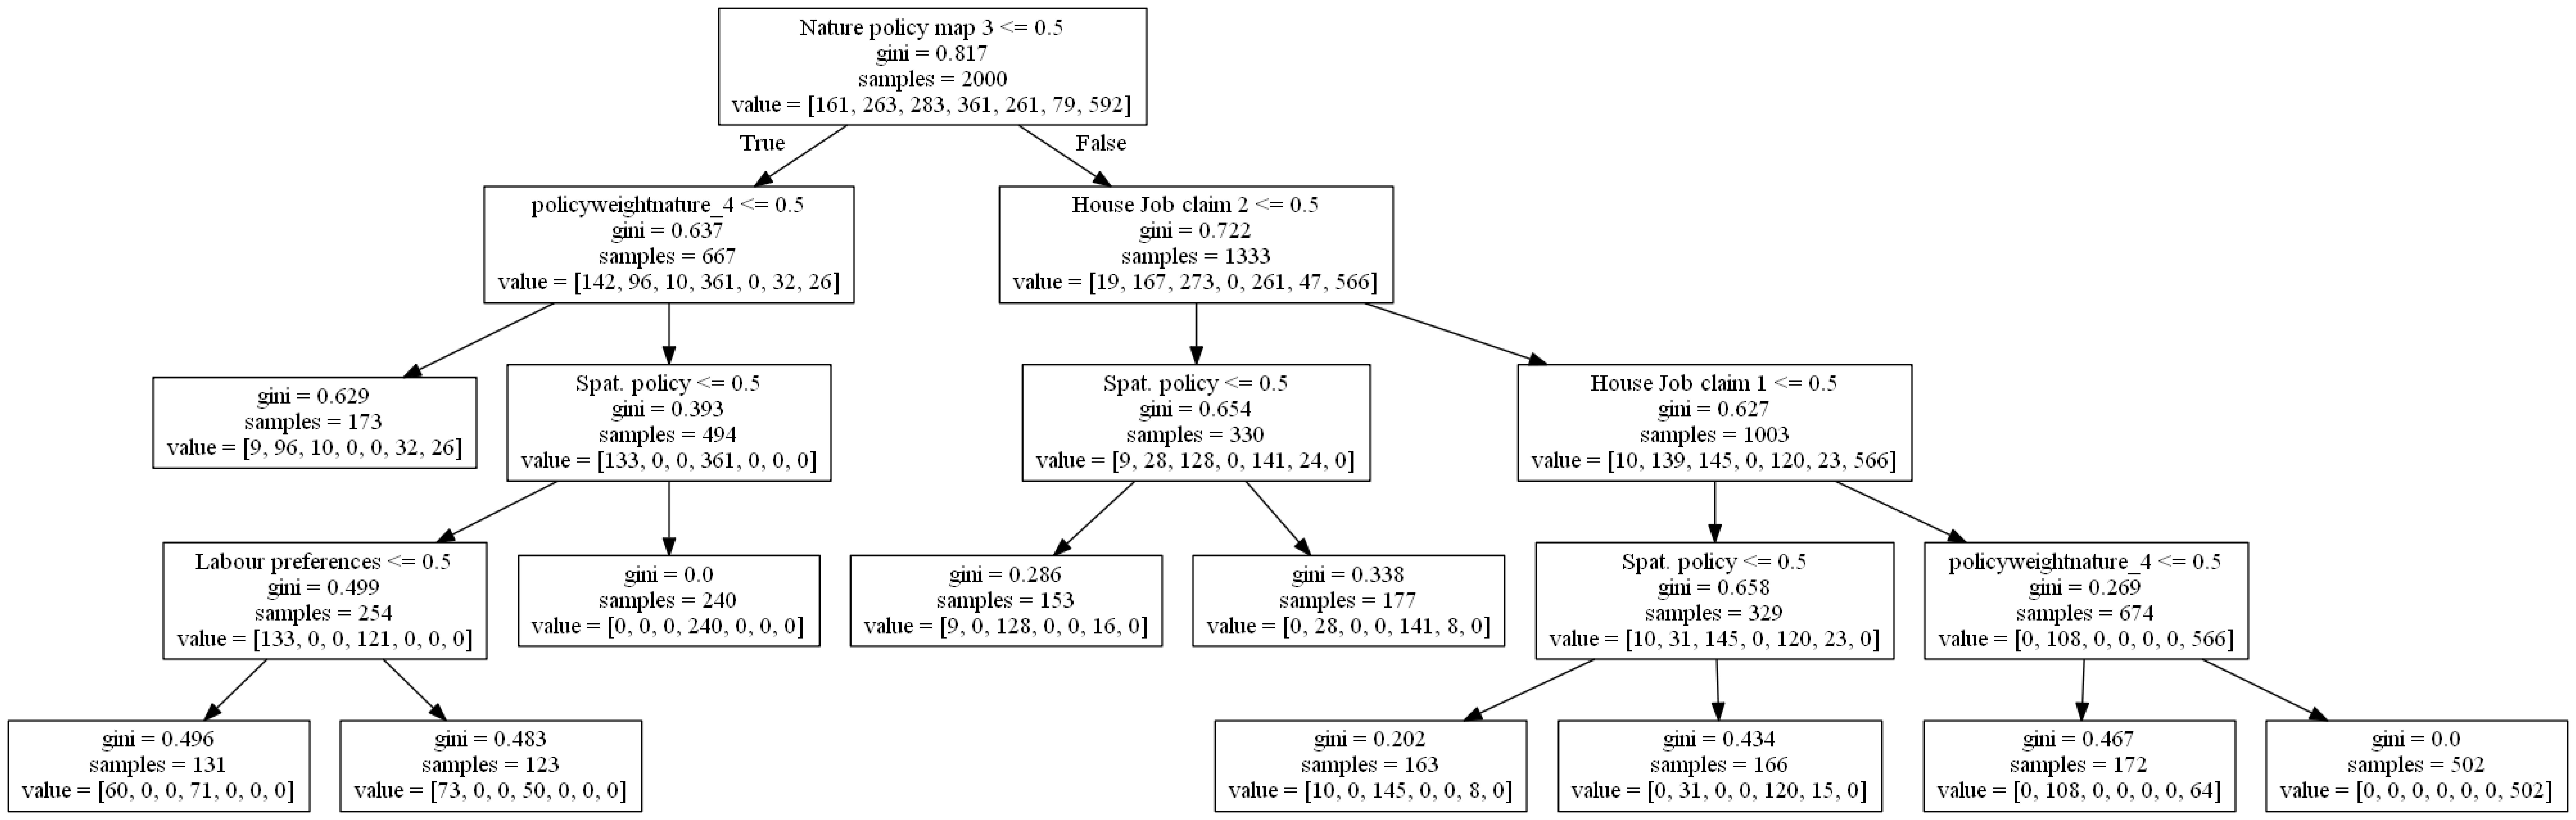

In [44]:
cart_kappa = cart.CART(dfCART, kappaclusters, mode = RuleInductionType.CLASSIFICATION)
cart_kappa.build_tree()
treeCART = cart_kappa.show_tree()
fig = plt.gcf()
fig.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()

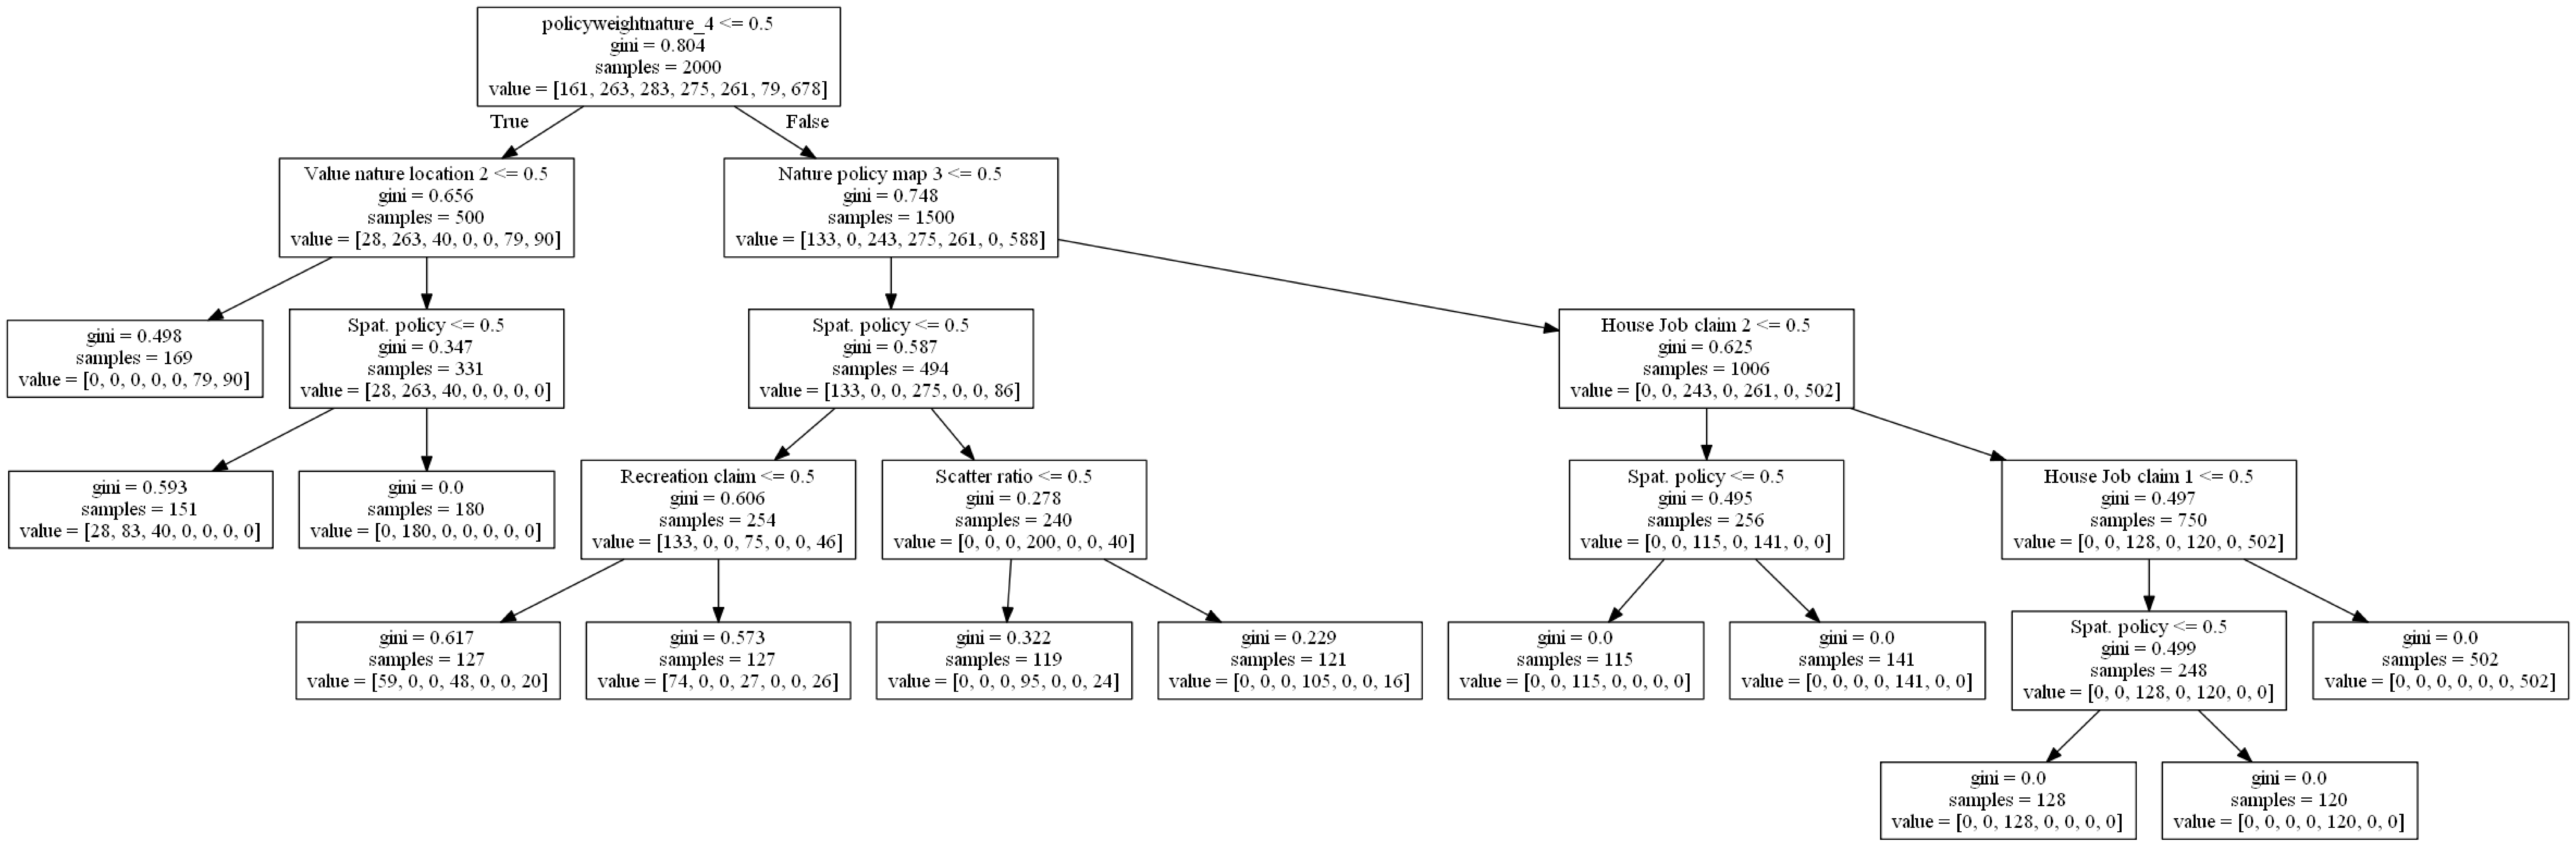

In [39]:
cart_oa= cart.CART(dfCART, oaclusters, mode=RuleInductionType.CLASSIFICATION)
cart_oa.build_tree()

tree_oa = cart_oa.show_tree()
fig = plt.gcf()
fig.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()

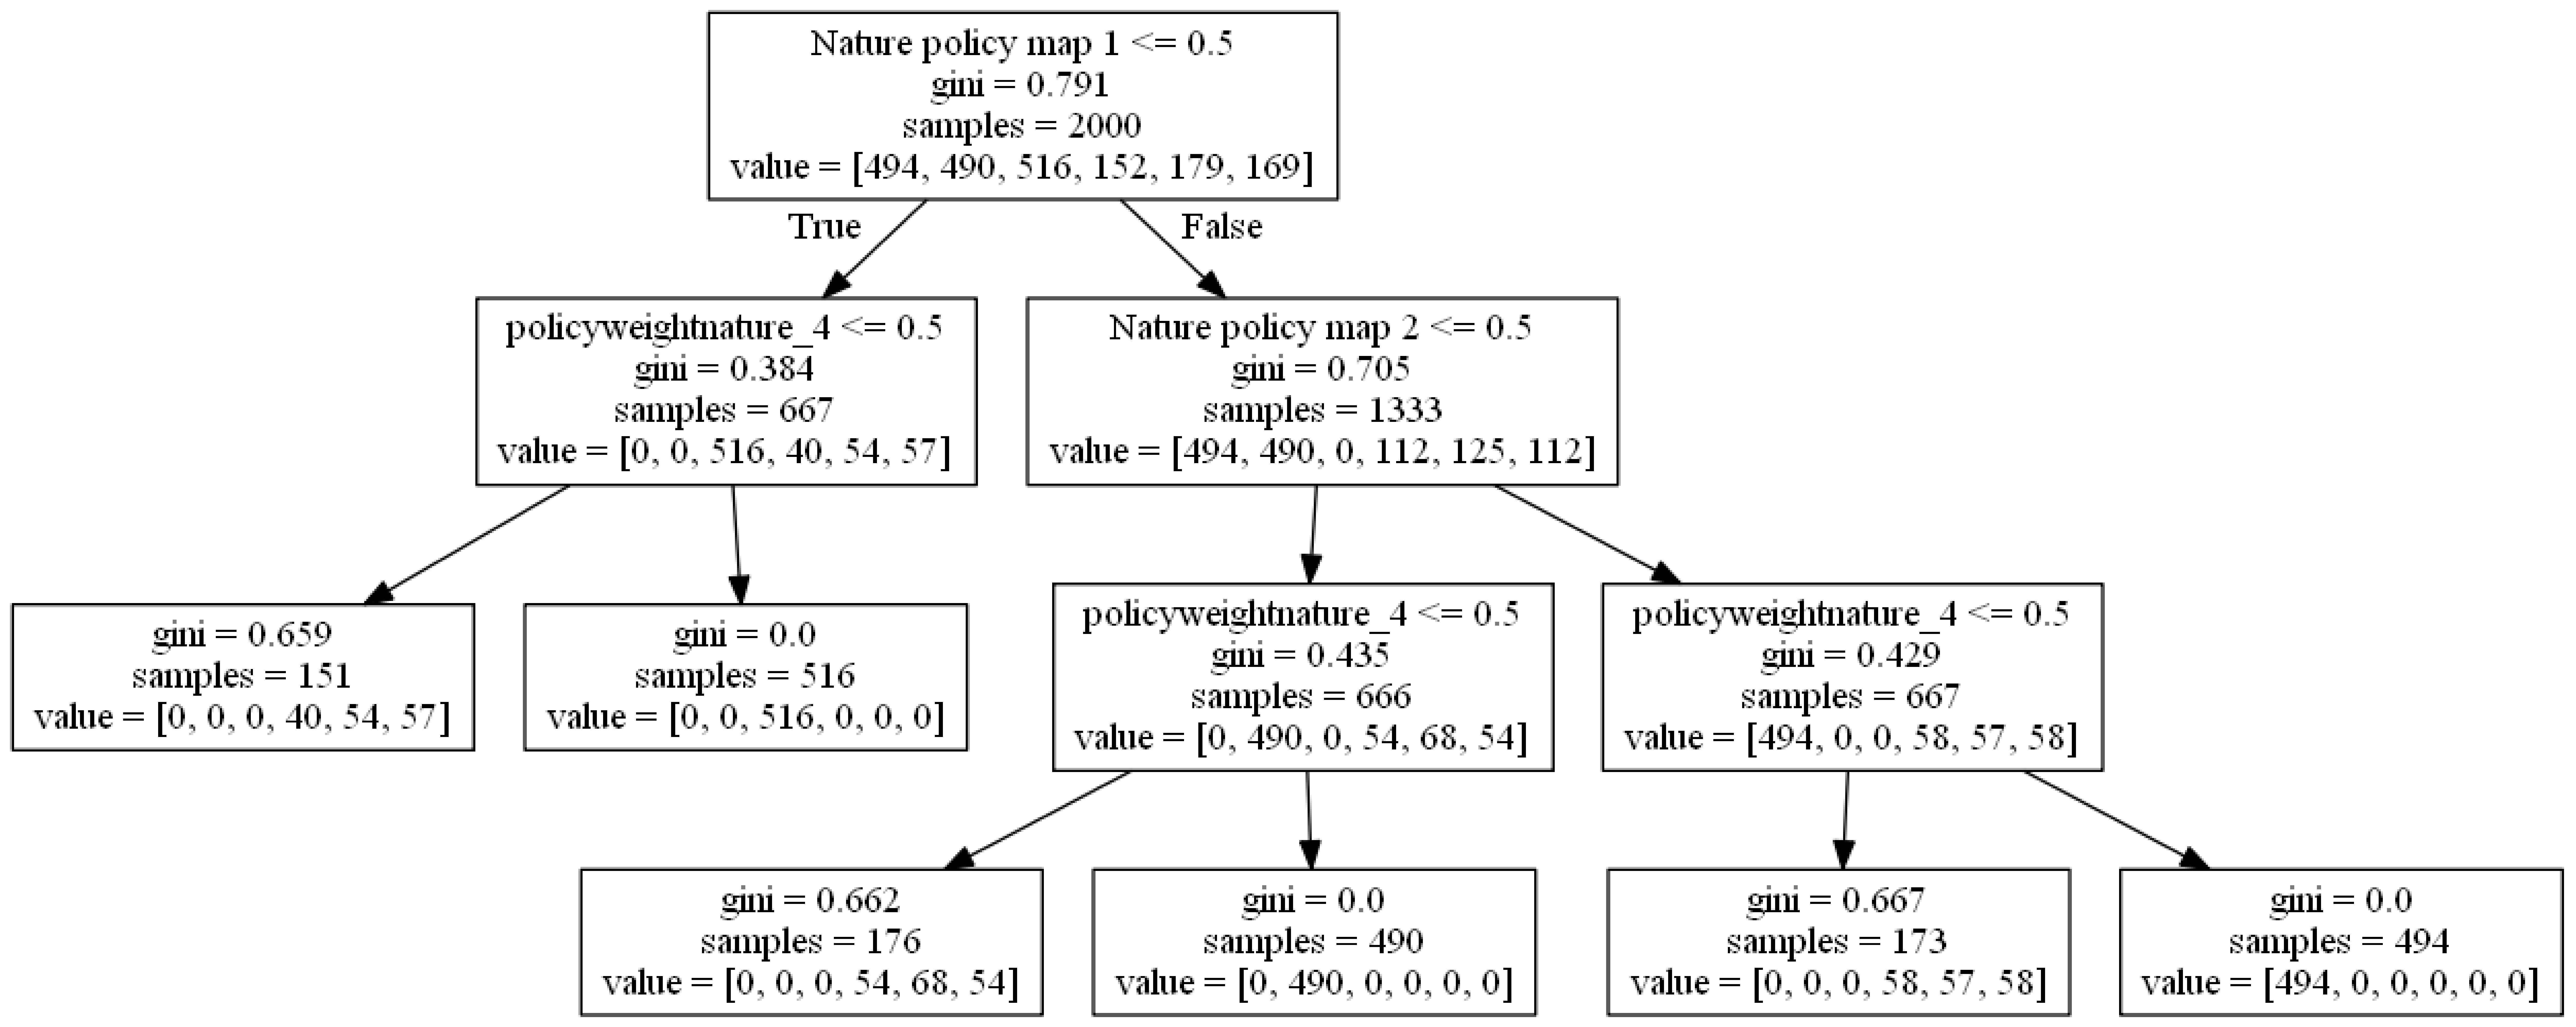

In [43]:
cart_oad= cart.CART(dfCART, oadclusters, mode=RuleInductionType.CLASSIFICATION)
cart_oad.build_tree()

tree_oad = cart_oad.show_tree()
fig = plt.gcf()
fig.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()

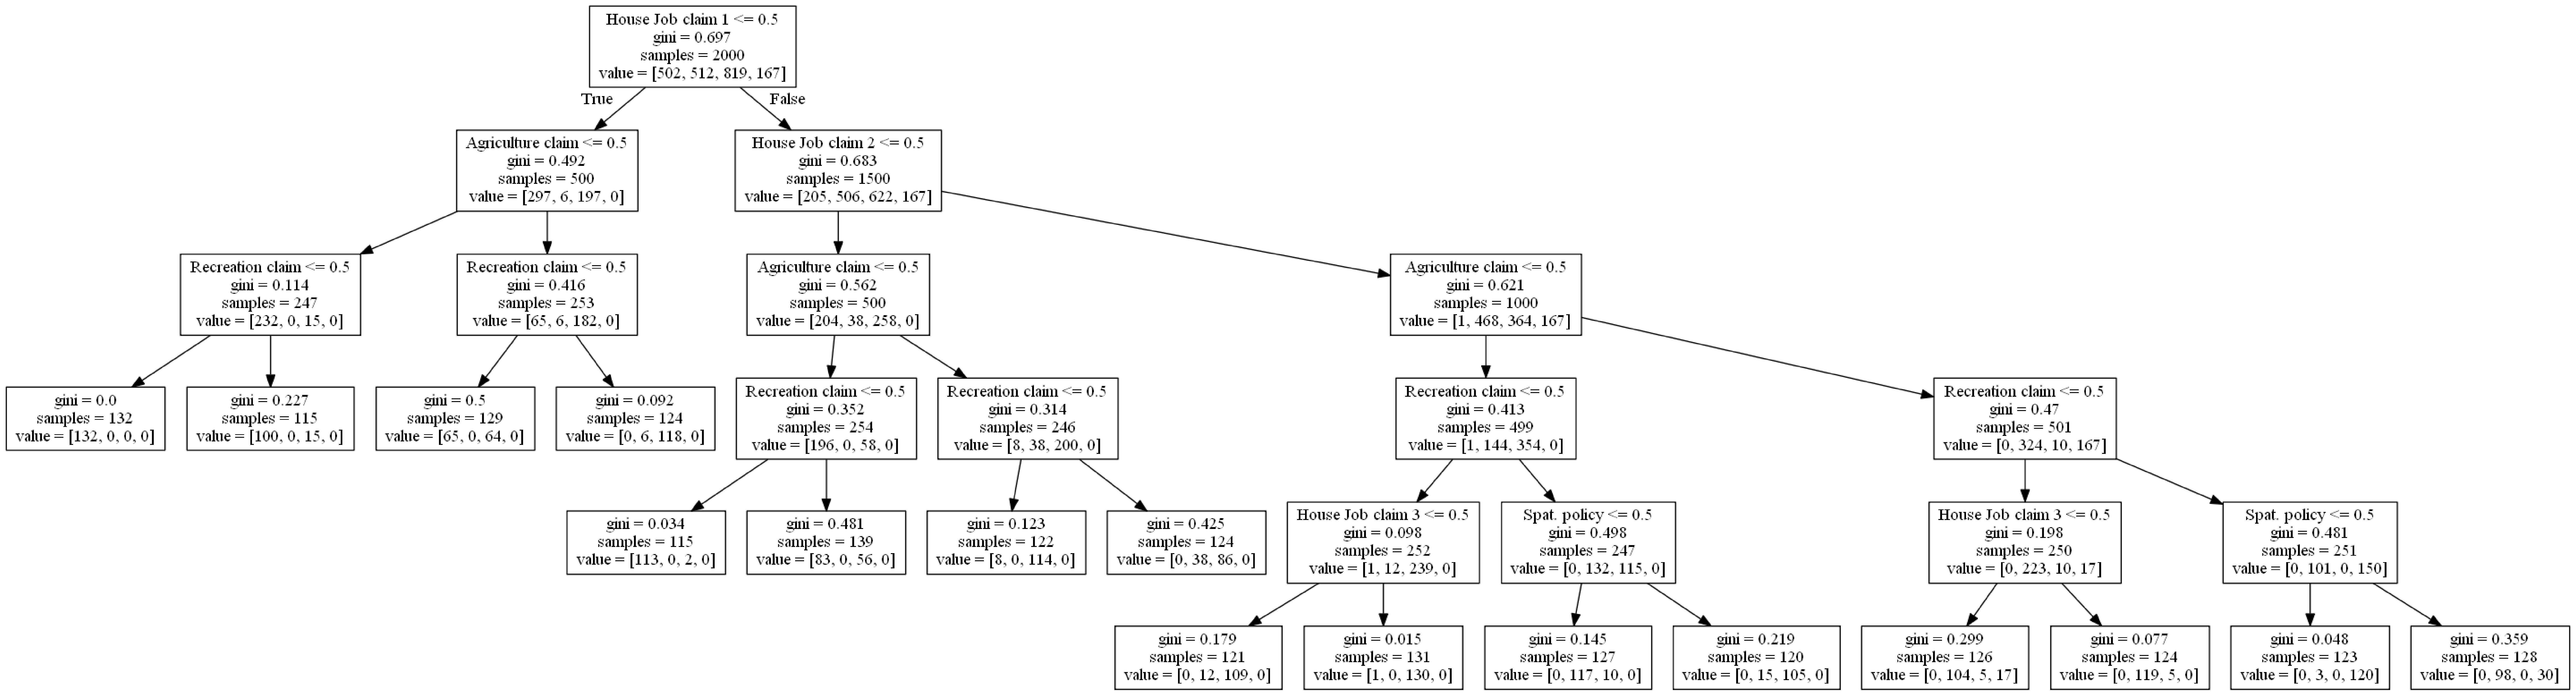

In [42]:
cart_shan= cart.CART(dfCART, shannonclusters, mode=RuleInductionType.CLASSIFICATION)
cart_shan.build_tree()

tree_shan = cart_shan.show_tree()
fig_shan = plt.gcf()
fig_shan.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()

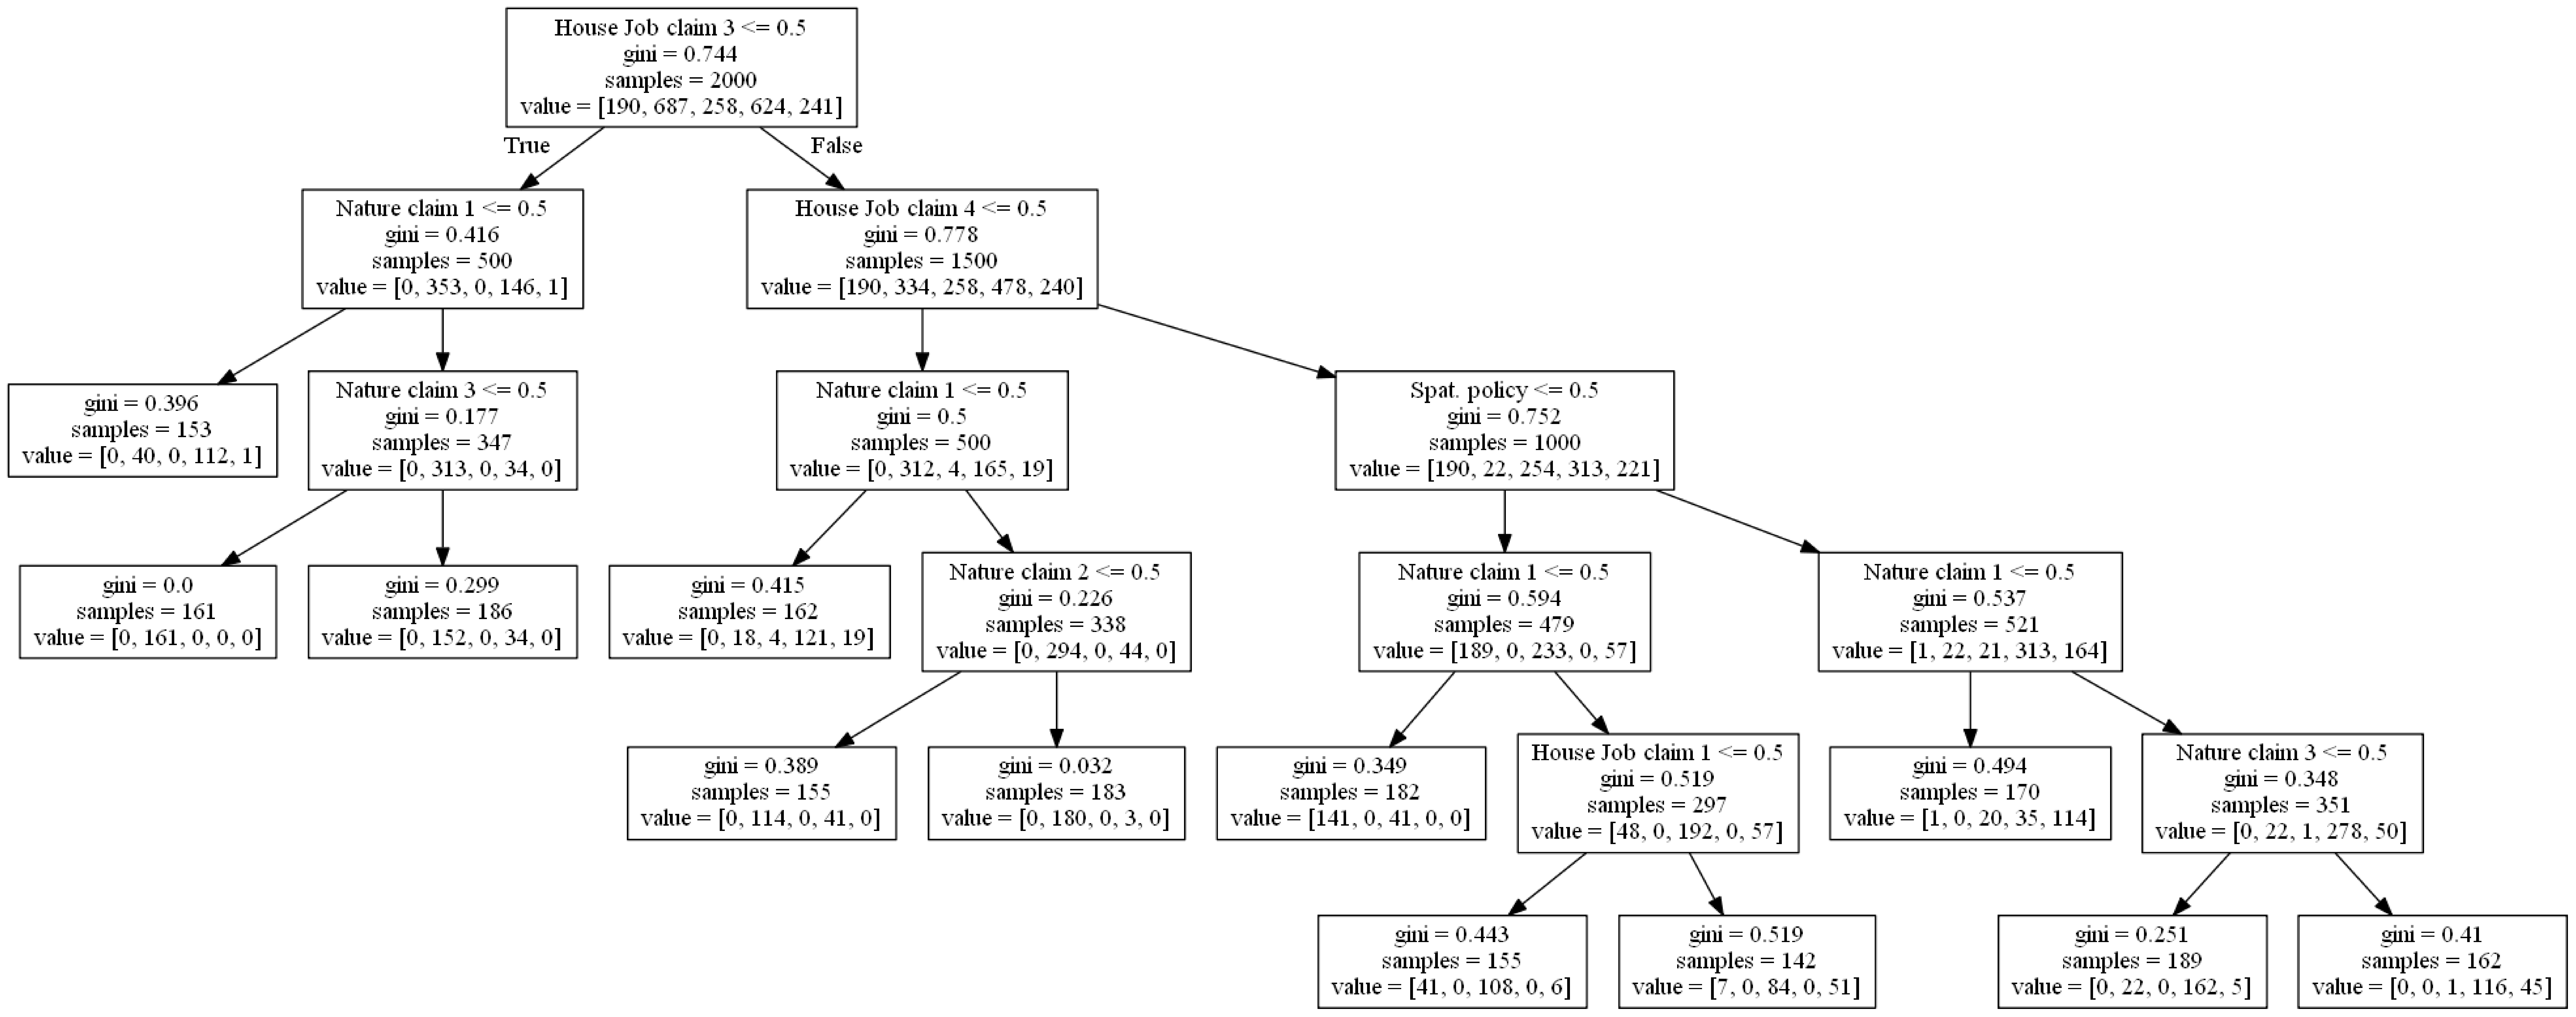

In [41]:
cart_tca14= cart.CART(dfCART, tca14clusters, mode=RuleInductionType.CLASSIFICATION)
cart_tca14.build_tree()

tree_tca14 = cart_tca14.show_tree()
fig_tca14 = plt.gcf()
fig_tca14.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()

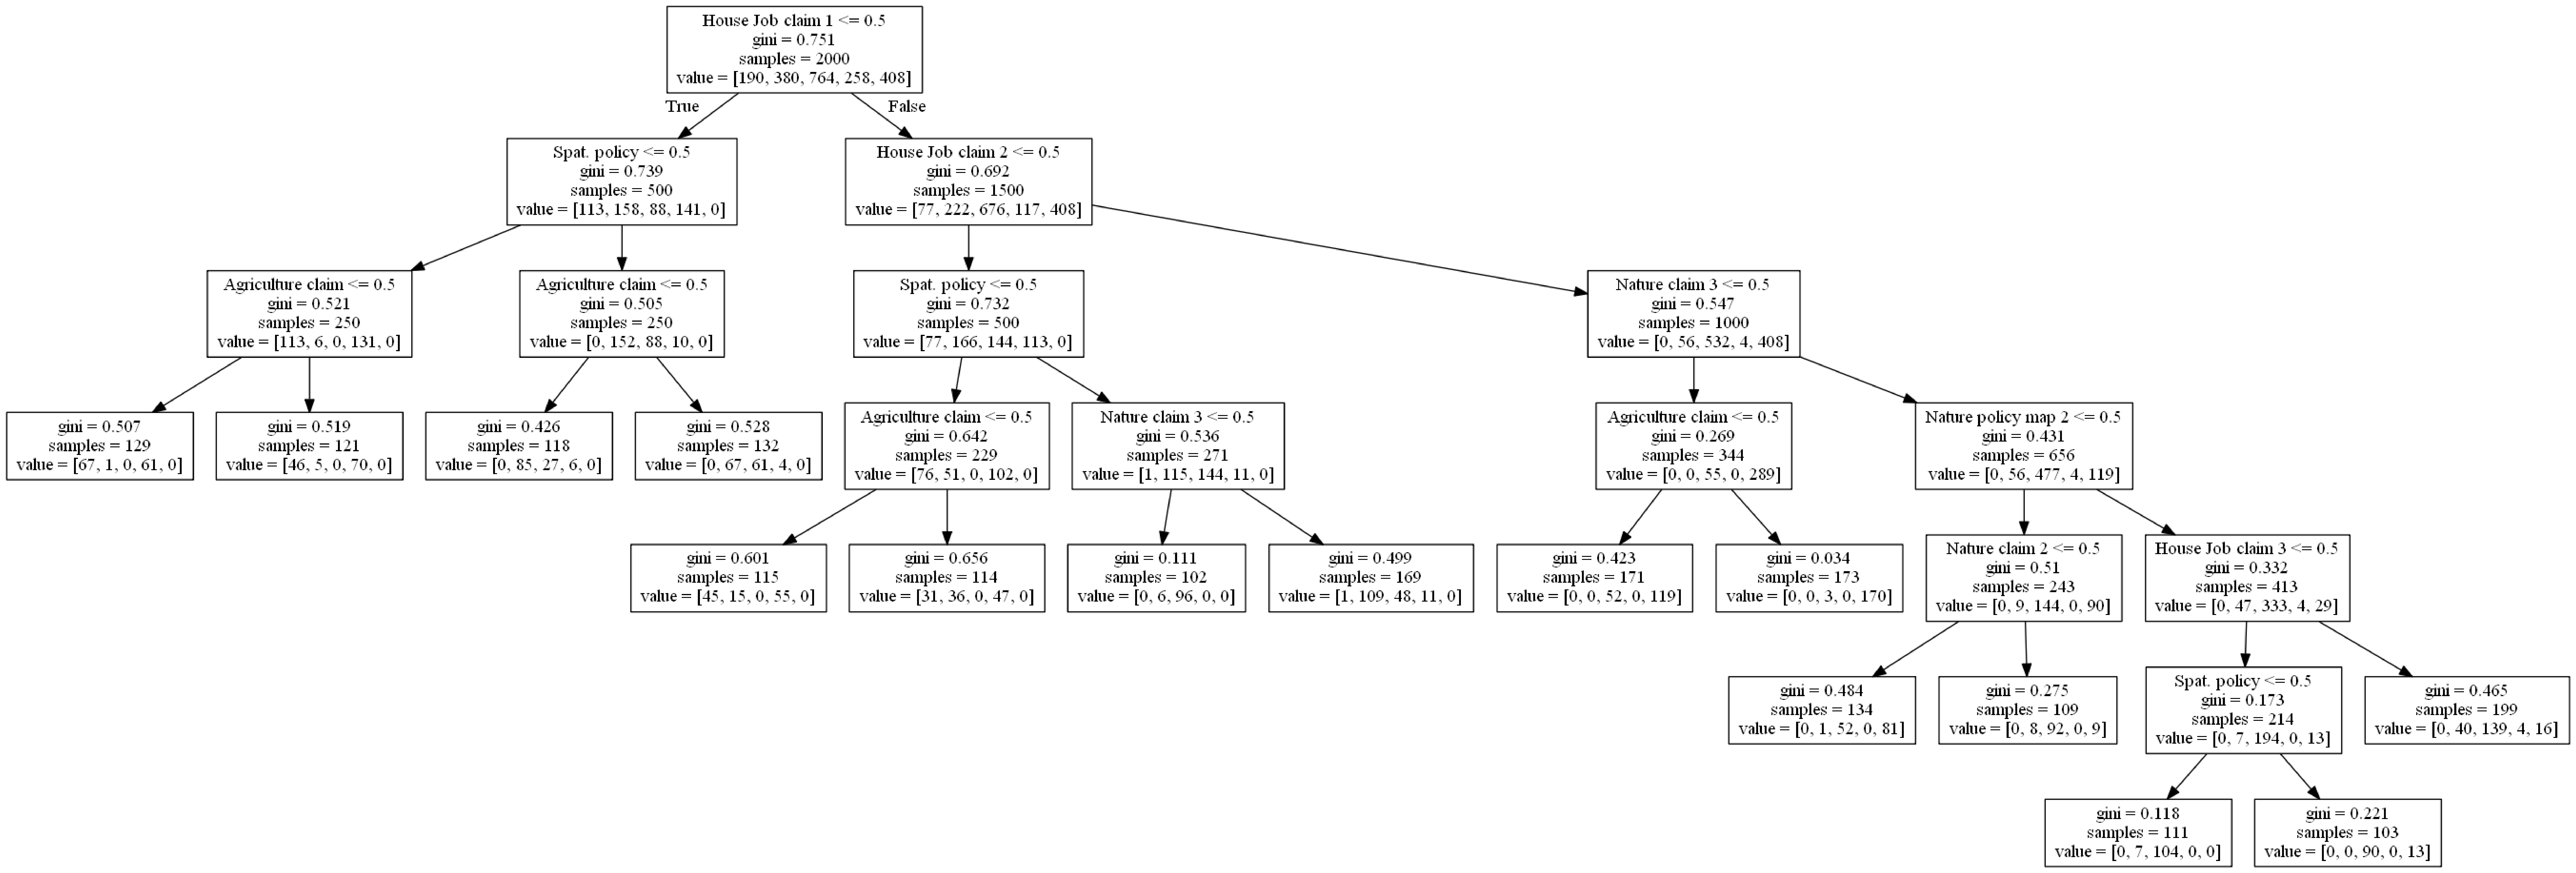

In [40]:
cart_pland14= cart.CART(dfCART, pland14clusters, mode=RuleInductionType.CLASSIFICATION)
cart_pland14.build_tree()

tree_pland14 = cart_pland14.show_tree()
fig_pland14 = plt.gcf()
fig_pland14.set_size_inches(200,200)

#treeCART.savefig('C:/Users/Admin_2/Documents/Thesis/NewExperiments/CART2000.png', dpi = 300)
plt.show()